# 네이버 영화 리뷰

In [1]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings('ignore')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)
train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


## 1. 데이터 전처리

In [3]:
# 전처리 하기 전 
print("==== train ====")
print("shape : ",train_data.shape)
print("document열 nunique: ",train_data['document'].nunique())
print("label열 nunique: ",train_data['label'].nunique())
print("==== test ====")
print("shape : ",test_data.shape)
print("document열 nunique: ",test_data['document'].nunique())
print("label열 nunique: ",test_data['label'].nunique())

==== train ====
shape :  (150000, 3)
document열 nunique:  146182
label열 nunique:  2
==== test ====
shape :  (50000, 3)
document열 nunique:  49157
label열 nunique:  2


In [4]:
# train_data 전처리

# 중복 제외
train_data.drop_duplicates(subset=['document'], inplace = True )
# null값 제외
print(train_data.isnull().sum())
train_data = train_data.dropna(how='any')
# 확인
print("==== 1차 확인 train ====")
print("shape : ",train_data.shape)
print("document열 nunique: ",train_data['document'].nunique())
print("label열 nunique: ",train_data['label'].nunique())
print("========================")
# 한글만 남기기
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
# 공백 제외
train_data['document'].replace('', np.nan, inplace=True)
# null값 제외
print(train_data.isnull().sum())
train_data = train_data.dropna(how='any')
# 확인
print("==== 2차 확인 train ====")
print("shape : ",train_data.shape)
print("document열 nunique: ",train_data['document'].nunique())
print("label열 nunique: ",train_data['label'].nunique())
print("========================")

id          0
document    1
label       0
dtype: int64
==== 1차 확인 train ====
shape :  (146182, 3)
document열 nunique:  146182
label열 nunique:  2
id            0
document    391
label         0
dtype: int64
==== 2차 확인 train ====
shape :  (145791, 3)
document열 nunique:  143681
label열 nunique:  2


In [5]:
# test_data 전처리

# 중복 제외
test_data.drop_duplicates(subset=['document'], inplace = True )
# null값 제외
print(test_data.isnull().sum())
test_data = test_data.dropna(how='any')
# 확인
print("==== 1차 확인 test ====")
print("shape : ",test_data.shape)
print("document열 nunique: ",test_data['document'].nunique())
print("label열 nunique: ",test_data['label'].nunique())
print("========================")
# 한글만 남기기
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
# 공백 제외
test_data['document'].replace('', np.nan, inplace=True)
# null값 제외
print(test_data.isnull().sum())
test_data = test_data.dropna(how='any')
# 확인
print("==== 2차 확인 test ====")
print("shape : ",test_data.shape)
print("document열 nunique: ",test_data['document'].nunique())
print("label열 nunique: ",test_data['label'].nunique())
print("========================")

id          0
document    1
label       0
dtype: int64
==== 1차 확인 test ====
shape :  (49157, 3)
document열 nunique:  49157
label열 nunique:  2
id            0
document    162
label         0
dtype: int64
==== 2차 확인 test ====
shape :  (48995, 3)
document열 nunique:  48417
label열 nunique:  2


In [6]:
# 불용어 

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

## 토큰화

>## 1. Mecab 형태소파싱 >> keras로 토큰화

In [7]:
mecab = Mecab()

In [8]:
# 데이터셋 정리

X_train = []
for sentences in train_data['document']:  
    X_train.append([word for word in mecab.morphs(sentences) if not word in stopwords])

X_test = []
for sentences in test_data['document']: 
    X_test.append([word for word in mecab.morphs(sentences) if not word in stopwords]) 
    
y_train = np.array(train_data['label'])

y_test = np.array(test_data['label'])

In [9]:
X_train[:3] # morphs parsing

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

In [10]:
# 토크나이징 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])
print(X_test[:3])
print("X_train len :",len(X_train))
print("y_train len :",len(y_train))
print("X_test len :",len(X_test))
print("y_test len :",len(y_test))

[[24, 64, 892, 30, 211, 12, 25, 696], [974, 478, 488, 633, 1, 107, 1551, 45, 863, 946, 8, 35, 361], [16, 189, 28634]]
[[785, 125], [74, 105, 49, 895, 311, 35, 28, 36, 594, 3398, 61, 852], [85, 4, 8, 35, 214, 122, 325, 116, 135, 46, 3, 6, 33]]
X_train len : 145791
y_train len : 145791
X_test len : 48995
y_test len : 48995


In [11]:
# 길이 1이하 제거

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


max_len: 83
everage_len: 13.801382583574082


Text(0.5, 0, 'Number')

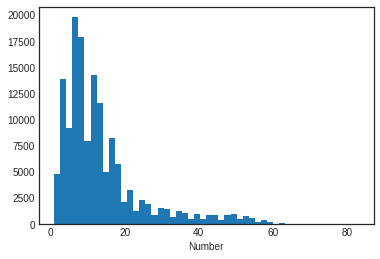

In [12]:
# 길이 분포 확인

print('max_len:', max(len(l) for l in X_train))
print('everage_len:', sum(map(len,X_train)) / len(X_train))

plt.hist([len(l) for l in X_train], bins=50)
plt.xlabel('Length')
plt.xlabel('Number')

In [13]:
# 해당 길이 몇프로인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list)) * 100)) 

In [14]:
# max_len

max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 97.91305544091347


In [15]:
# 패딩하기

X_train = pad_sequences(X_train,maxlen=max_len)
X_test = pad_sequences(X_test,maxlen=max_len)

## LSTM 모델링

In [16]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 8000

model = Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
              loss = "binary_crossentropy",
              metrics = ['acc'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         800000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 917,377
Trainable params: 917,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1818/1818 [==============================] - 15s 6ms/step - loss: 0.3873 - acc: 0.8235 - val_loss: 0.3500 - val_acc: 0.8446
Epoch 2/15
1818/1818 [==============================] - 11s 6ms/step - loss: 0.3254 - acc: 0.8580 - val_loss: 0.3409 - val_acc: 0.8496
Epoch 3/15
1818/1818 [==============================] - 11s 6ms/step - loss: 0.3026 - acc: 0.8702 - val_loss: 

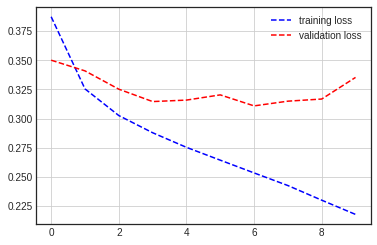

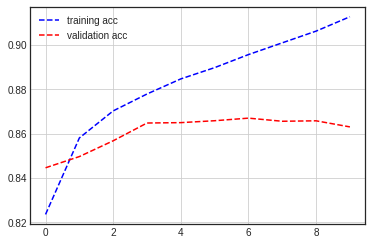

In [18]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

>## 2. Okt 형태소파싱 >> keras로 토큰화

In [19]:
from konlpy.tag import Okt
okt = Okt()

In [20]:
# 데이터셋 정리

X_train = []
for sentences in train_data['document']:  
    X_train.append([word for word in okt.morphs(sentences) if not word in stopwords])

X_test = []
for sentences in test_data['document']: 
    X_test.append([word for word in okt.morphs(sentences) if not word in stopwords]) 
    
y_train = np.array(train_data['label'])

y_test = np.array(test_data['label'])



In [21]:
X_train[:3] # morphs parsing

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'],
 ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '다']]

In [22]:
# 토크나이징 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])
print(X_test[:3])
print("X_train len :",len(X_train))
print("y_train len :",len(y_train))
print("X_test len :",len(X_test))
print("y_test len :",len(y_test))

[[40, 417, 8, 6598, 624], [905, 419, 31, 567, 1, 182, 1521, 12, 939, 6036, 25784], [357, 2813, 45383, 2646, 7326, 12028, 189, 4]]
[[784, 75], [50, 143, 14, 4668, 1406, 10, 946, 847, 36, 757, 3696], [14620, 2449, 72, 307, 94, 88, 371, 130, 237]]
X_train len : 145791
y_train len : 145791
X_test len : 48995
y_test len : 48995


In [23]:
# 길이 1이하 제거

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145383
145383


max_len: 72
everage_len: 11.22376068728806


Text(0.5, 0, 'Number')

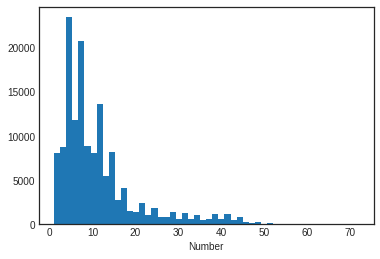

In [24]:
# 길이 분포 확인

print('max_len:', max(len(l) for l in X_train))
print('everage_len:', sum(map(len,X_train)) / len(X_train))

plt.hist([len(l) for l in X_train], bins=50)
plt.xlabel('Length')
plt.xlabel('Number')

In [25]:
# 해당 길이 몇프로인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list)) * 100)) 

In [26]:
# max_len

max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 97.6276455981786


In [27]:
# 패딩하기

X_train = pad_sequences(X_train,maxlen=max_len)
X_test = pad_sequences(X_test,maxlen=max_len)

## LSTM 모델링

In [28]:
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 8000

model = Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
              loss = "binary_crossentropy",
              metrics = ['acc'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         800000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 917,377
Trainable params: 917,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1818/1818 [==============================] - 14s 6ms/step - loss: 0.4004 - acc: 0.8137 - val_loss: 0.3785 - val_acc: 0.8368
Epoch 2/15
1818/1818 [==============================] - 10s 6ms/step - loss: 0.3401 - acc: 0.8490 - val_loss: 0.3487 - val_acc: 0.8431
Epoch 3/15
1818/1818 [==============================] - 10s 6ms/step - loss: 0.3228 - acc: 0.8574 - val_loss

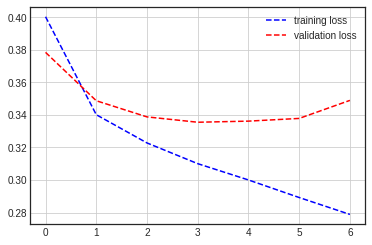

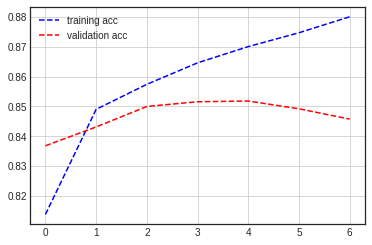

In [29]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

>## 3. Sentencepiece

In [30]:
examples = train_data['document']

In [31]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in examples:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n') # 줄별로 불러오고
        
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*   

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 377815 Feb 16 05:57 korean_spm.model
-rw-r--r-- 1 root root 147291 Feb 16 05:57 korean_spm.vocab


In [32]:
import sentencepiece as spm

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')  # load the pre-trained SentencePiece model


True

In [33]:
# 1. prefix로 parsing 어떻게 했나 확인하기

def texts_to_pieces(sentences):
    pieces = []
    for sen  in sentences:
        token_pieces = s.EncodeAsPieces(sen)
        pieces.append(token_pieces)
    return pieces

texts_to_pieces(examples[:1])

[['▁아', '▁더빙', '▁진짜', '▁짜증나', '네요', '▁목소리']]

In [34]:
# 2. 인코딩, 디코딩해보기

def encoded_decoded(sentences):
    sequences = []
    for sen in sentences:
        token_ids = s.EncodeAsIds(sen)
        sequences.append(token_ids)
    
    texts = []
    for seq in sequences:
        text_pieces = s.DecodeIds(seq)
        texts.append(text_pieces)
    return sequences, texts

In [35]:
encoded_output, decoded_output = encoded_decoded(examples)
print(encoded_output[:1])
print(decoded_output[:1])

[[55, 792, 25, 2028, 54, 1717]]
['아 더빙 진짜 짜증나네요 목소리']


max_len: 140
everage_len: 33.013999492424084


Text(0.5, 0, 'Number')

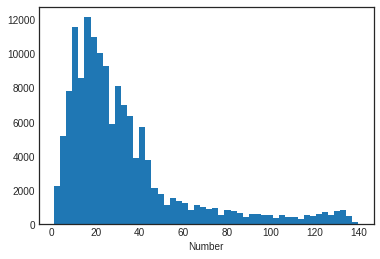

In [36]:
# 길이 분포 확인

print('max_len:', max(len(l) for l in examples))
print('everage_len:', sum(map(len,examples)) / len(examples))

plt.hist([len(l) for l in examples], bins=50)
plt.xlabel('Length')
plt.xlabel('Number')

In [37]:
# 해당 길이 몇프로인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list)) * 100)) 

In [38]:
# max_len

max_len = 120
below_threshold_len(max_len, examples)

전체 샘플 중 길이가 120 이하인 샘플의 비율: 97.15894671138821


In [39]:
# 3. 단어사전 & 패딩하기

def dictionary(sentences):
    # 1. text_to_pieces 파싱
    pieces = []
    for sen in sentences:
        token_pieces = s.EncodeAsPieces(sen)
        pieces.append(token_pieces)
    
    # 2의 toatl_vocab 지정하기위해 전체 데이터셋을 한번 더 불러와 len셈.
    with open("./korean_spm.vocab", 'r') as f:
        total_vocab = f.readlines()
    
    # 2. 단어사전 두가지 리스트 만들기
    word_index = {}
    index_word = {}

    for idx, line in enumerate(total_vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    
    # 3. 패딩하기
    tensor = []
    for sen in sentences:
        tensor.append(s.EncodeAsIds(sen))
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, word_index, index_word

In [40]:
tensor, word_index, index_word = dictionary(examples)
print(tensor[:1])
# print(word_index)
# print(index_word)
print(tensor.shape)

[[  55  792   25 2028   54 1717    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
(145791, 116)


In [41]:
print(X_train.shape)

(145383, 40)


In [42]:
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 8000

model = Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
              loss = "binary_crossentropy",
              metrics = ['acc'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         800000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 917,377
Trainable params: 917,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1818/1818 [==============================] - 13s 6ms/step - loss: 0.4032 - acc: 0.8139 - val_loss: 0.3620 - val_acc: 0.8373
Epoch 2/15
1818/1818 [==============================] - 10s 6ms/step - loss: 0.3407 - acc: 0.8482 - val_loss: 0.3471 - val_acc: 0.8441
Epoch 3/15
1818/1818 [==============================] - 11s 6ms/step - loss: 0.3233 - acc: 0.8575 - val_loss

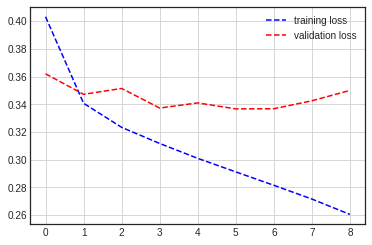

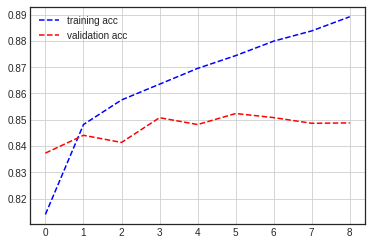

In [43]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

평가문항	상세기준
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?

코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?

SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?

SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.


데이터는 97% 정도로 맞춰 자름

# 회고  
## 1. mecab > Tokenizer  
[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']  
Test accuracy: 0.8602102398872375  
## 2. okt > Tokenizer
['아', '더빙', '진짜', '짜증나네요', '목소리'],  
Test accuracy: 0.8399224281311035  
## 3. Sentencepiece
[['▁아', '▁더빙', '▁진짜', '▁짜증나', '네요', '▁목소리']]  
Test accuracy: 0.8408204913139343  

데이터는 각각 정제 후 97% 수준이 되도록 끊었고, 
vocab size, layer conditions 등은 모두 동일하게 줬다.
결과가 mecab이 sentencepiece 보다 좋게 나왔는데,
예제 문장을 split 한 것을 보면 더빙을 더 빙으로 끊으면서 사실상 그렇게 자연스럽지 않아 결과에 의문이 남기는 한다. 
노드학습때에도 형태소 분석기 간의 결과를 보고 가장 한국어같이 끊어내던 mecab과 okt가 원픽이라 함께 해봤는데,
사실 끊기는 okt가 훨씬 자연스러워도 test acc는 mecab이 더 좋았다.

끊은 것이 자연스럽기로는 okt보다 sentencepiece가 훨씬 자연스럽다. 나중에 다른문장이 많아져도 조사정도를 따로 분리해뒀기 때문에 단어사전의 갯수가 폭발적으로 많아지는 것도 줄일 수 있을 것 같다.

연산속도는 확실히 okt가 많이 느렸다..


시간이 더 있었으면
sentencepiece에 사전학습시켰던 korean-english-park.train.ko.temp 말고 다른 것을 시도해보고 싶다.
